In [17]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
# Create an array of temperatures for 2 weeks
temperature = np.arange(1, 15)
print(temperature)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [9]:
window_size = 3
batch_size = 2
shuffle_buffer = 10

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(temperature)
print("After from_tensor_slices:")
for element in dataset:
    print(element.numpy())


After from_tensor_slices:
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [11]:
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
print("\nAfter window:")
for window in dataset:
    window_data = ' '.join([str(element.numpy()) for element in window])
    print(window_data)



After window:
1 2 3 4
2 3 4 5
3 4 5 6
4 5 6 7
5 6 7 8
6 7 8 9
7 8 9 10
8 9 10 11
9 10 11 12
10 11 12 13
11 12 13 14


In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
print("\nAfter flat_map:")
for element in dataset:
    print(element.numpy())


After flat_map:
[1 2 3 4]
[2 3 4 5]
[3 4 5 6]
[4 5 6 7]
[5 6 7 8]
[6 7 8 9]
[ 7  8  9 10]
[ 8  9 10 11]
[ 9 10 11 12]
[10 11 12 13]
[11 12 13 14]


In [13]:
dataset = dataset.shuffle(shuffle_buffer)
print("\nAfter shuffle:")
for element in dataset:
    print(element.numpy())



After shuffle:
[10 11 12 13]
[1 2 3 4]
[2 3 4 5]
[ 9 10 11 12]
[6 7 8 9]
[4 5 6 7]
[11 12 13 14]
[3 4 5 6]
[5 6 7 8]
[ 8  9 10 11]
[ 7  8  9 10]


In [14]:
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
print("\nAfter map:")
for x,y in dataset:
    print("features =", x.numpy(), "label =", y.numpy())


After map:
features = [1 2 3] label = 4
features = [2 3 4] label = 5
features = [6 7 8] label = 9
features = [ 8  9 10] label = 11
features = [ 9 10 11] label = 12
features = [7 8 9] label = 10
features = [10 11 12] label = 13
features = [5 6 7] label = 8
features = [4 5 6] label = 7
features = [3 4 5] label = 6
features = [11 12 13] label = 14


In [15]:
dataset = dataset.batch(batch_size).prefetch(1)
print("\nAfter batch and prefetch:")
for batch in dataset:
    print(batch)




After batch and prefetch:
(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[6, 7, 8],
       [4, 5, 6]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([9, 7])>)
(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[ 9, 10, 11],
       [ 2,  3,  4]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([12,  5])>)
(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[10, 11, 12],
       [ 3,  4,  5]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([13,  6])>)
(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[ 8,  9, 10],
       [ 5,  6,  7]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([11,  8])>)
(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[ 1,  2,  3],
       [11, 12, 13]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 4, 14])>)
(<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[7, 8, 9]])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([10])>)


#Sales forecasting with NN

In [21]:
# URL of the dataset
url = 'https://raw.githubusercontent.com/PacktPublishing/TensorFlow-Developer-Certificate-Guide/main/Chapter%2012/sales_data.csv'
# Load the dataset
df = pd.read_csv(url)
df.head()

,Date,Sales
0,2013-01-01,48.40
1,2013-01-02,49.63
2,2013-01-03,44.66
3,2013-01-04,56.70
4,2013-01-05,62.87


In [22]:
time = pd.to_datetime(df['Date'])
sales = df['Sales'].values

In [23]:
split_time = int(len(df) * 0.8)
time_train = time[:split_time]
x_train = sales[:split_time]
time_valid = time[split_time:]
x_valid = sales[split_time:]

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [29]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [30]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


forecast = []
for time in range(len(sales) - window_size):
  forecast.append(model.predict(sales[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


1/1 [==============================] - 0s 30ms/step


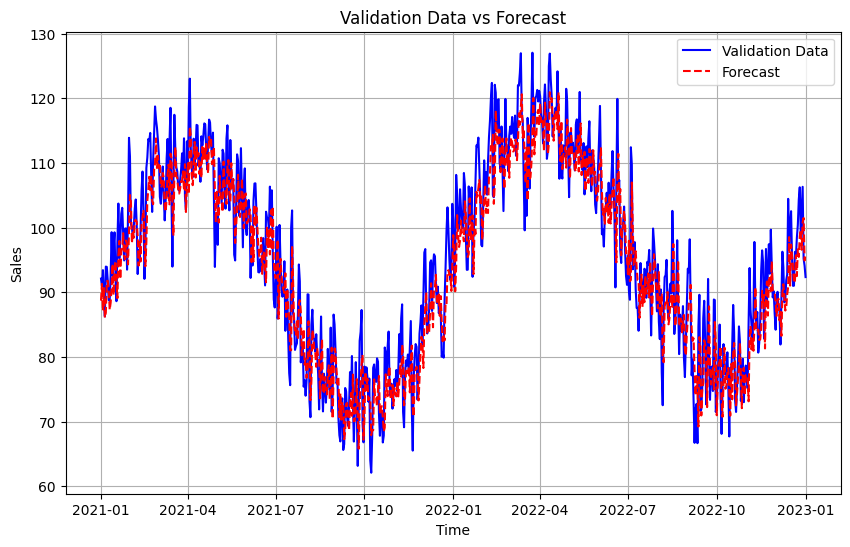

Mean Squared Error: 30.522306
Mean Absolute Error: 4.4181085


(30.522306, 4.4181085)

In [31]:
def plot_forecast(valid_time, valid_data, forecast_data):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_time, valid_data, label="Validation Data", color='blue')
    plt.plot(valid_time, forecast_data, label="Forecast", color='red', linestyle='--')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.title("Validation Data vs Forecast")
    plt.grid(True)
    plt.show()

plot_forecast(time_valid, x_valid, results)


def calculate_errors(y_true, y_pred):
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy()
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()
    print('Mean Squared Error:', mse)
    print('Mean Absolute Error:', mae)
    return mse, mae

# Calculate and print the errors
calculate_errors(x_valid, results)